# creazione dataset 

In [1]:
library(dplyr)
library(readr)
library(lubridate)
library(purrr)
library(tools)
library(ggplot2)
library(gridExtra)
library(stats)
library(R2jags)
library(coda)


Caricamento pacchetto: 'dplyr'


I seguenti oggetti sono mascherati da 'package:stats':

    filter, lag


I seguenti oggetti sono mascherati da 'package:base':

    intersect, setdiff, setequal, union



Caricamento pacchetto: 'lubridate'


I seguenti oggetti sono mascherati da 'package:base':

    date, intersect, setdiff, union



Caricamento pacchetto: 'gridExtra'


Il seguente oggetto `e mascherato da 'package:dplyr':

    combine


Caricamento del pacchetto richiesto: rjags

Caricamento del pacchetto richiesto: coda

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs


Caricamento pacchetto: 'R2jags'


Il seguente oggetto `e mascherato da 'package:coda':

    traceplot




In [115]:

create_dataset <- function(Monthly=FALSE,Yearly=FALSE) {
      
      data_folder <- "./datiarpav"
    
      # Ottenere la lista di tutti i file con estensione .csv
      file_csv <- list.files(path = data_folder, pattern = "*.csv", full.names = TRUE)    
      # Creare un dataframe combinando i dati dai file CSV
      df <- file_csv |>
            map_df(~ read_csv(.x, show_col_types = FALSE) |>
            na.omit() |>
            mutate(file = file_path_sans_ext(basename(.x)),
                   month = ym(format(date, "%Y-%m")),
                   year_only = year(date))) |>
            filter(date >= as.Date('1993-01-01') & date <= as.Date('2021-12-31')) |>
            relocate( month, year_only, file, .after = date) |>
            arrange(date)     
            
      # Aggiungere colonne year e month_only
      df <- df |>
            mutate(month_only = as.double(format(month, "%m"))) |>
            relocate(month_only, .after = year_only)

      # dataset con summary mensii
      if(Monthly){
            df <- df |> group_by(month) |> summarise(MIN_mean = mean(TMIN), MED_mean = mean(TMED), MAX_mean = mean(TMAX)) |> 
                  mutate(year_only = as.double(format(month, "%Y")), month_only = as.double(format(month, "%m")))|>
            relocate(month_only, year_only, .after = month)
      }
      # dataset con summary annuali 
      if(Yearly){
            df <- df |> group_by(year_only) |> summarise(MIN_mean = mean(TMIN), MED_mean = mean(TMED), MAX_mean = mean(TMAX))
      }

    return(df)
}

# funzione per analizzare singoli mesi 
month_analisis <- function(df, n){
      m_df <- df[df$month_only == n,]
      return(m_df)
}

# heatmap che analizza evoluzione temperature su base mensile 
create_heatmap <- function(df, str){
    time_interval = 10              # mesi finestra temporale precedente su cui fare la media
    years <- unique(df$year_only)   
    num_years <- length(years)
    heatmap_data <- data.frame()
    
    for (n in 1:12) {
        month_evolution <- month_analisis(df, n)      # estraiamo una summary dei mesi 
        if(str == 'min'){
            month_temp <- month_evolution$MIN_mean     # estraiamo solo la temperatura     
        }  
        else if(str == 'max'){
            month_temp <- month_evolution$MAX_mean     
        }    
        else(str == 'ava')
            month_temp <- month_evolution$MED_mean 
        
        diff <- c()
        
        for (t in (time_interval+1):length(month_temp)) {         # computiamo la differenza tra temperatura di un anno e la media dei 10 anni precedenti
            t_mean <- mean(month_temp[(t-time_interval):(t-1)])
            diff_i <- month_temp[t] - t_mean
            diff <- c(diff, diff_i)
        }
        
        temp_df <- data.frame(                        # costruiamo la heatmap 
            Month = rep(n, length(diff)),
            Year = month_evolution$year_only[(time_interval+1):length(month_temp)],
            Difference = diff
        )
        heatmap_data <- rbind(heatmap_data, temp_df)
    }
    
    # plot 
    heatmap_plot <- ggplot(heatmap_data, aes(x = Year, y = Month, fill = Difference)) +
        geom_tile() +
        scale_fill_gradient2(low = "navy", mid = "white", high = "orange", midpoint = 0) +
        labs(title = "Monthly Temperature difference w.r.t. 10 years before",
             x = "Year",
             y = "Month",
             fill = "Difference") +
        theme_bw()


    return(list(heatmap_plot, heatmap_data))
}


In [116]:
daily_dataset <- create_dataset()
monthly_dataset <- create_dataset(Monthly =   TRUE) 
yearly_dataset <- create_dataset(Yearly = TRUE)

head(monthly_dataset, 5)
tail(yearly_dataset, 5)

month,month_only,year_only,MIN_mean,MED_mean,MAX_mean
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1993-01-01,1,1993,-2.7709677,0.7212567,4.888940
1993-02-01,2,1993,-3.7118518,2.0787911,8.875138
1993-03-01,3,1993,0.2251634,5.5080083,11.212235
1993-04-01,4,1993,5.5535714,10.8663607,16.347619
1993-05-01,5,1993,11.0829493,17.2318825,23.499078


year_only,MIN_mean,MED_mean,MAX_mean
<dbl>,<dbl>,<dbl>,<dbl>
2017,6.933232,11.98327,17.81874
2018,8.209399,12.78718,18.17328
2019,7.886683,12.58039,18.04659
2020,7.423109,12.32396,18.01893
2021,6.750020,11.72077,17.39425


# Part 0
## prima visualizzazione / analisi 


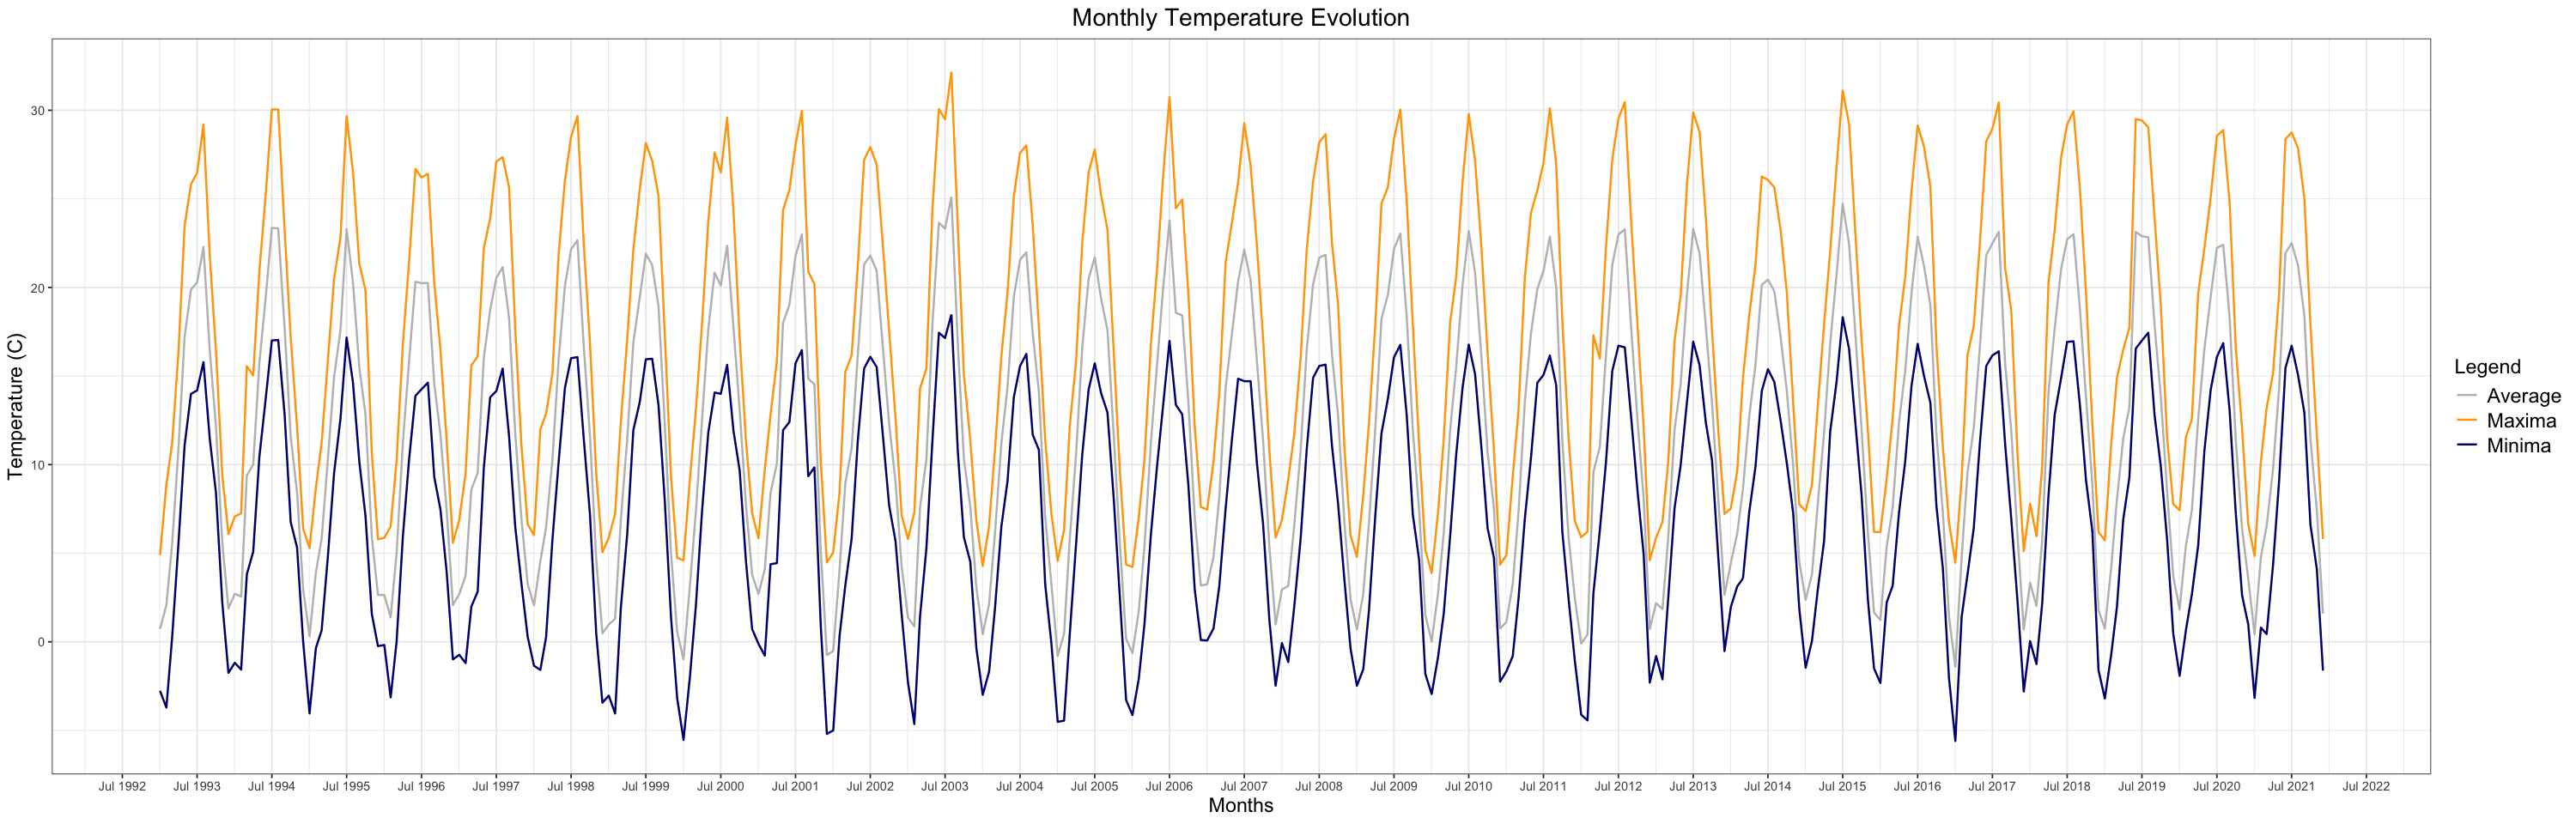

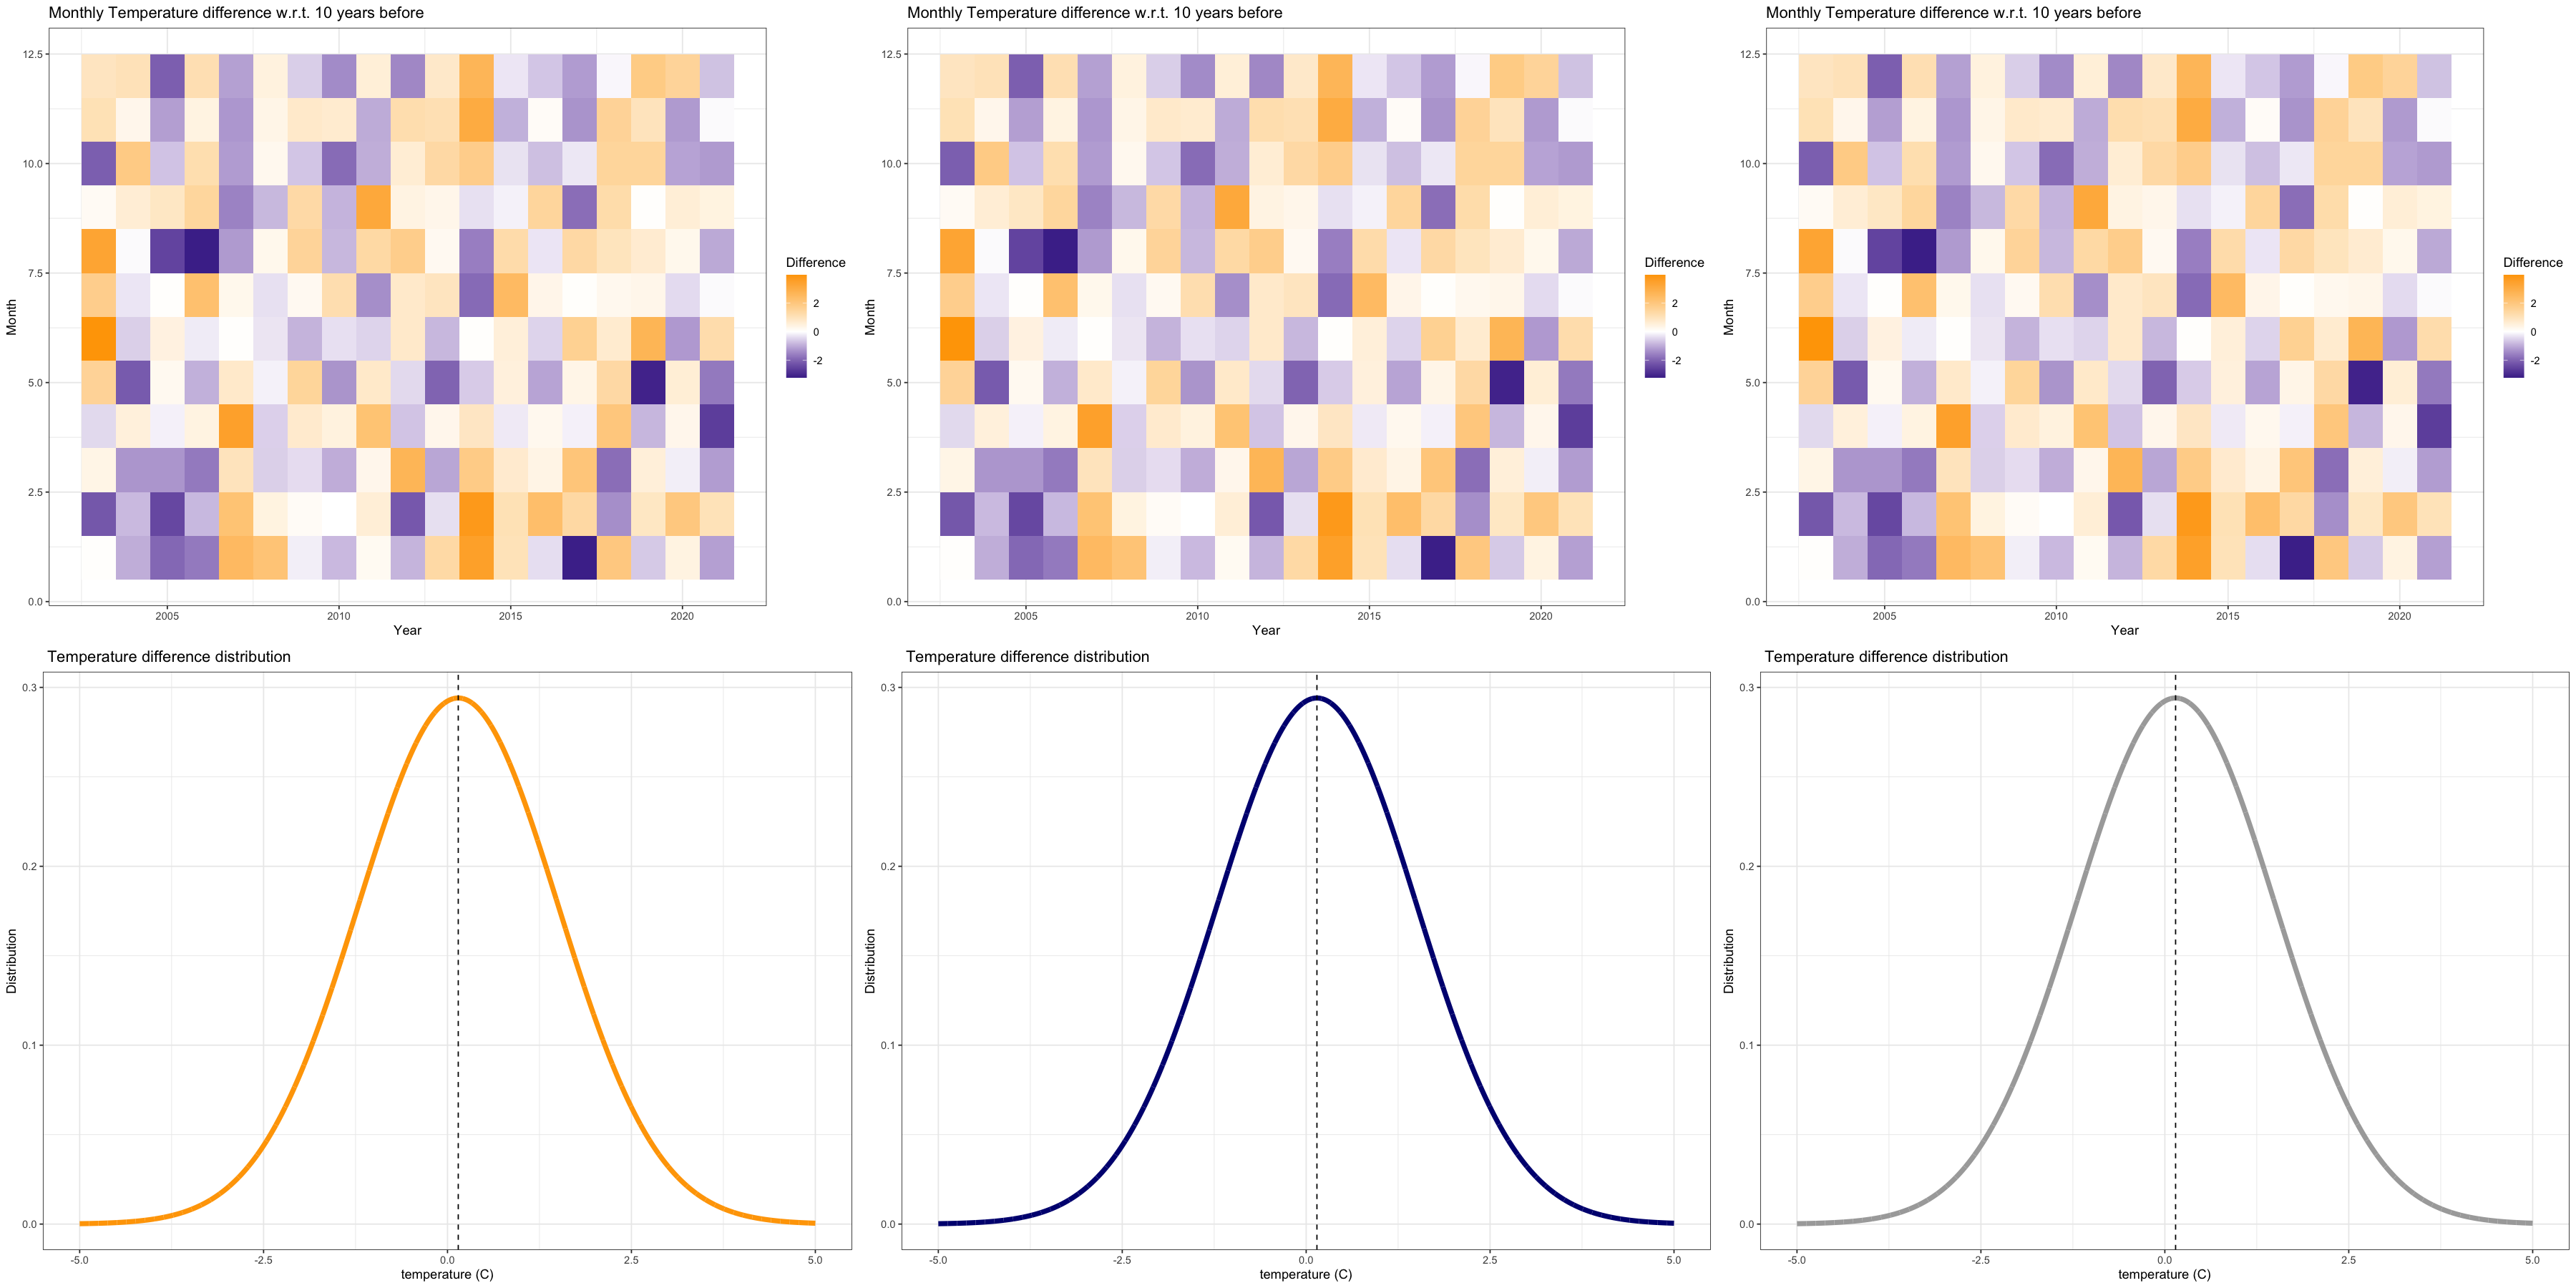

In [117]:
# Imposta la larghezza e l'altezza del plot
options(repr.plot.width = 25, repr.plot.height = 8)

# Grafico mensile
p_m <- ggplot(data = monthly_dataset) +
  geom_line(aes(x = month, y = MED_mean, color = 'Average'), group = 1, linewidth = 0.7) +
  geom_line(aes(x = month, y = MIN_mean, color = 'Minima'), group = 1, linewidth = 0.7) +
  geom_line(aes(x = month, y = MAX_mean, color = 'Maxima'), group = 1, linewidth = 0.7) +
  scale_color_manual(name = 'Legend', values = c('Minima' = 'navy', 'Maxima' = 'orange', 'Average' = 'gray')) +
  labs(title = 'Monthly Temperature Evolution',
       x = 'Months',
       y = 'Temperature (C)') +
  scale_x_date(date_breaks = "12 month", date_labels = "%b %Y") +
  theme_bw() +
  theme(plot.title = element_text(size = 17, hjust = 0.5),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 14),
        legend.title = element_text(size = 14))

# Visualizza il grafico mensile
print(p_m)

h_max <- create_heatmap(df = monthly_dataset, str = 'max')
h_max_mean <- mean(h_max[[2]]$Difference)
h_max_var <- var(h_max[[2]]$Difference)
h_min <- create_heatmap(df = monthly_dataset, str = 'min')
h_min_mean <- mean(h_min[[2]]$Difference)
h_min_var <- var(h_min[[2]]$Difference)
h_ava <- create_heatmap(df = monthly_dataset, str = 'ava')
h_ava_mean <- mean(h_ava[[2]]$Difference)
h_ava_var <- var(h_ava[[2]]$Difference)

x_axis = seq(-5,5,0.001)

max_dist = dnorm(x=x_axis,sd = sqrt(h_max_var), mean = h_max_mean)
min_dist = dnorm(x=x_axis,sd = sqrt(h_min_var), mean = h_min_mean)
ava_dist = dnorm(x=x_axis,sd = sqrt(h_ava_var), mean = h_ava_mean)
df_max <- data.frame(x = x_axis, y = max_dist)
df_min <- data.frame(x = x_axis, y = min_dist)
df_ava <- data.frame(x = x_axis, y = ava_dist)


plot_max <- ggplot(df_max, aes(x = x, y = y)) + 
  geom_line(color = 'orange', linewidth = 2) + 
  geom_vline(aes(xintercept = h_max_mean), linetype = 2) +
  theme_bw()+
  labs(title = ' Temperature difference distribution ',
       x = 'temperature (C)',
       y = 'Distribution') 

plot_min <- ggplot(df_min, aes(x = x, y = y)) + 
  geom_line(color = 'navy', linewidth = 2) + 
  geom_vline(aes(xintercept = h_min_mean), linetype = 2) +
  theme_bw()+
  labs(title = ' Temperature difference distribution ',
       x = 'temperature (C)',
       y = 'Distribution') 

plot_ava <- ggplot(df_ava, aes(x = x, y = y)) + 
  geom_line(color = 'darkgray', linewidth = 2) + 
  geom_vline(aes(xintercept = h_ava_mean), linetype = 2) +
  theme_bw()+
  labs(title = ' Temperature difference distribution ',
       x = 'temperature (C)',
       y = 'Distribution') 

options(repr.plot.width = 30, repr.plot.height = 15)
grid.arrange(h_max[[1]], h_min[[1]], h_ava[[1]], 
             plot_max, plot_min, plot_ava, 
             ncol = 3, nrow = 2)





# Part 1

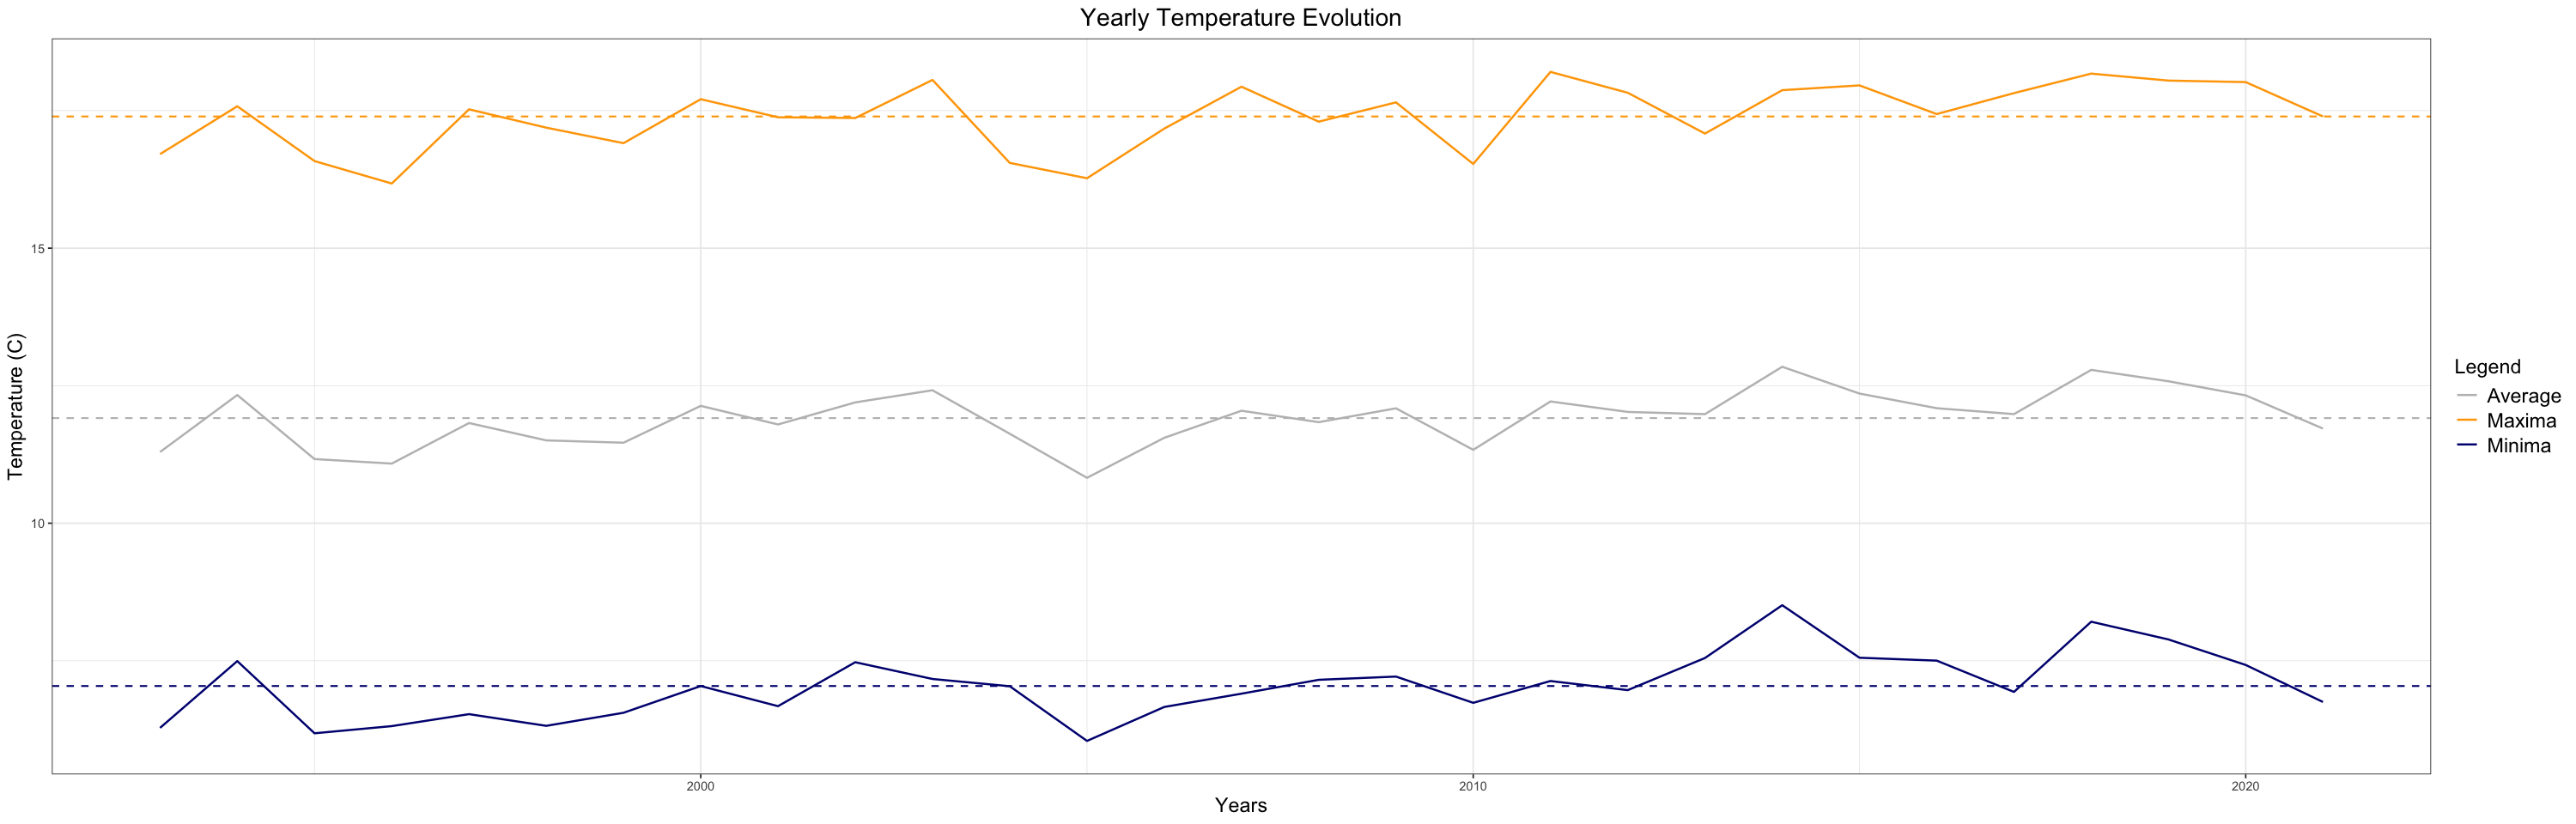

In [118]:
options(repr.plot.width = 25, repr.plot.height = 8)
# Grafico annuale
p_y <- ggplot(data = yearly_dataset) +
  geom_line(aes(x = year_only, y = MED_mean, color = 'Average'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MED_mean)), color = 'gray', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MIN_mean, color = 'Minima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MIN_mean)), color = 'navy', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MAX_mean, color = 'Maxima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MAX_mean)), color = 'orange', linewidth = 0.6, linetype = 2)+  
  scale_color_manual(name = 'Legend', values = c('Minima' = 'navy', 'Maxima' = 'orange', 'Average' = 'gray')) +
  labs(title = 'Yearly Temperature Evolution',
       x = 'Years',
       y = 'Temperature (C)') +
  theme_bw() +
  theme(plot.title = element_text(size = 17, hjust = 0.5),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 14),
        legend.title = element_text(size = 14))

# Visualizza il grafico annuale
print(p_y)

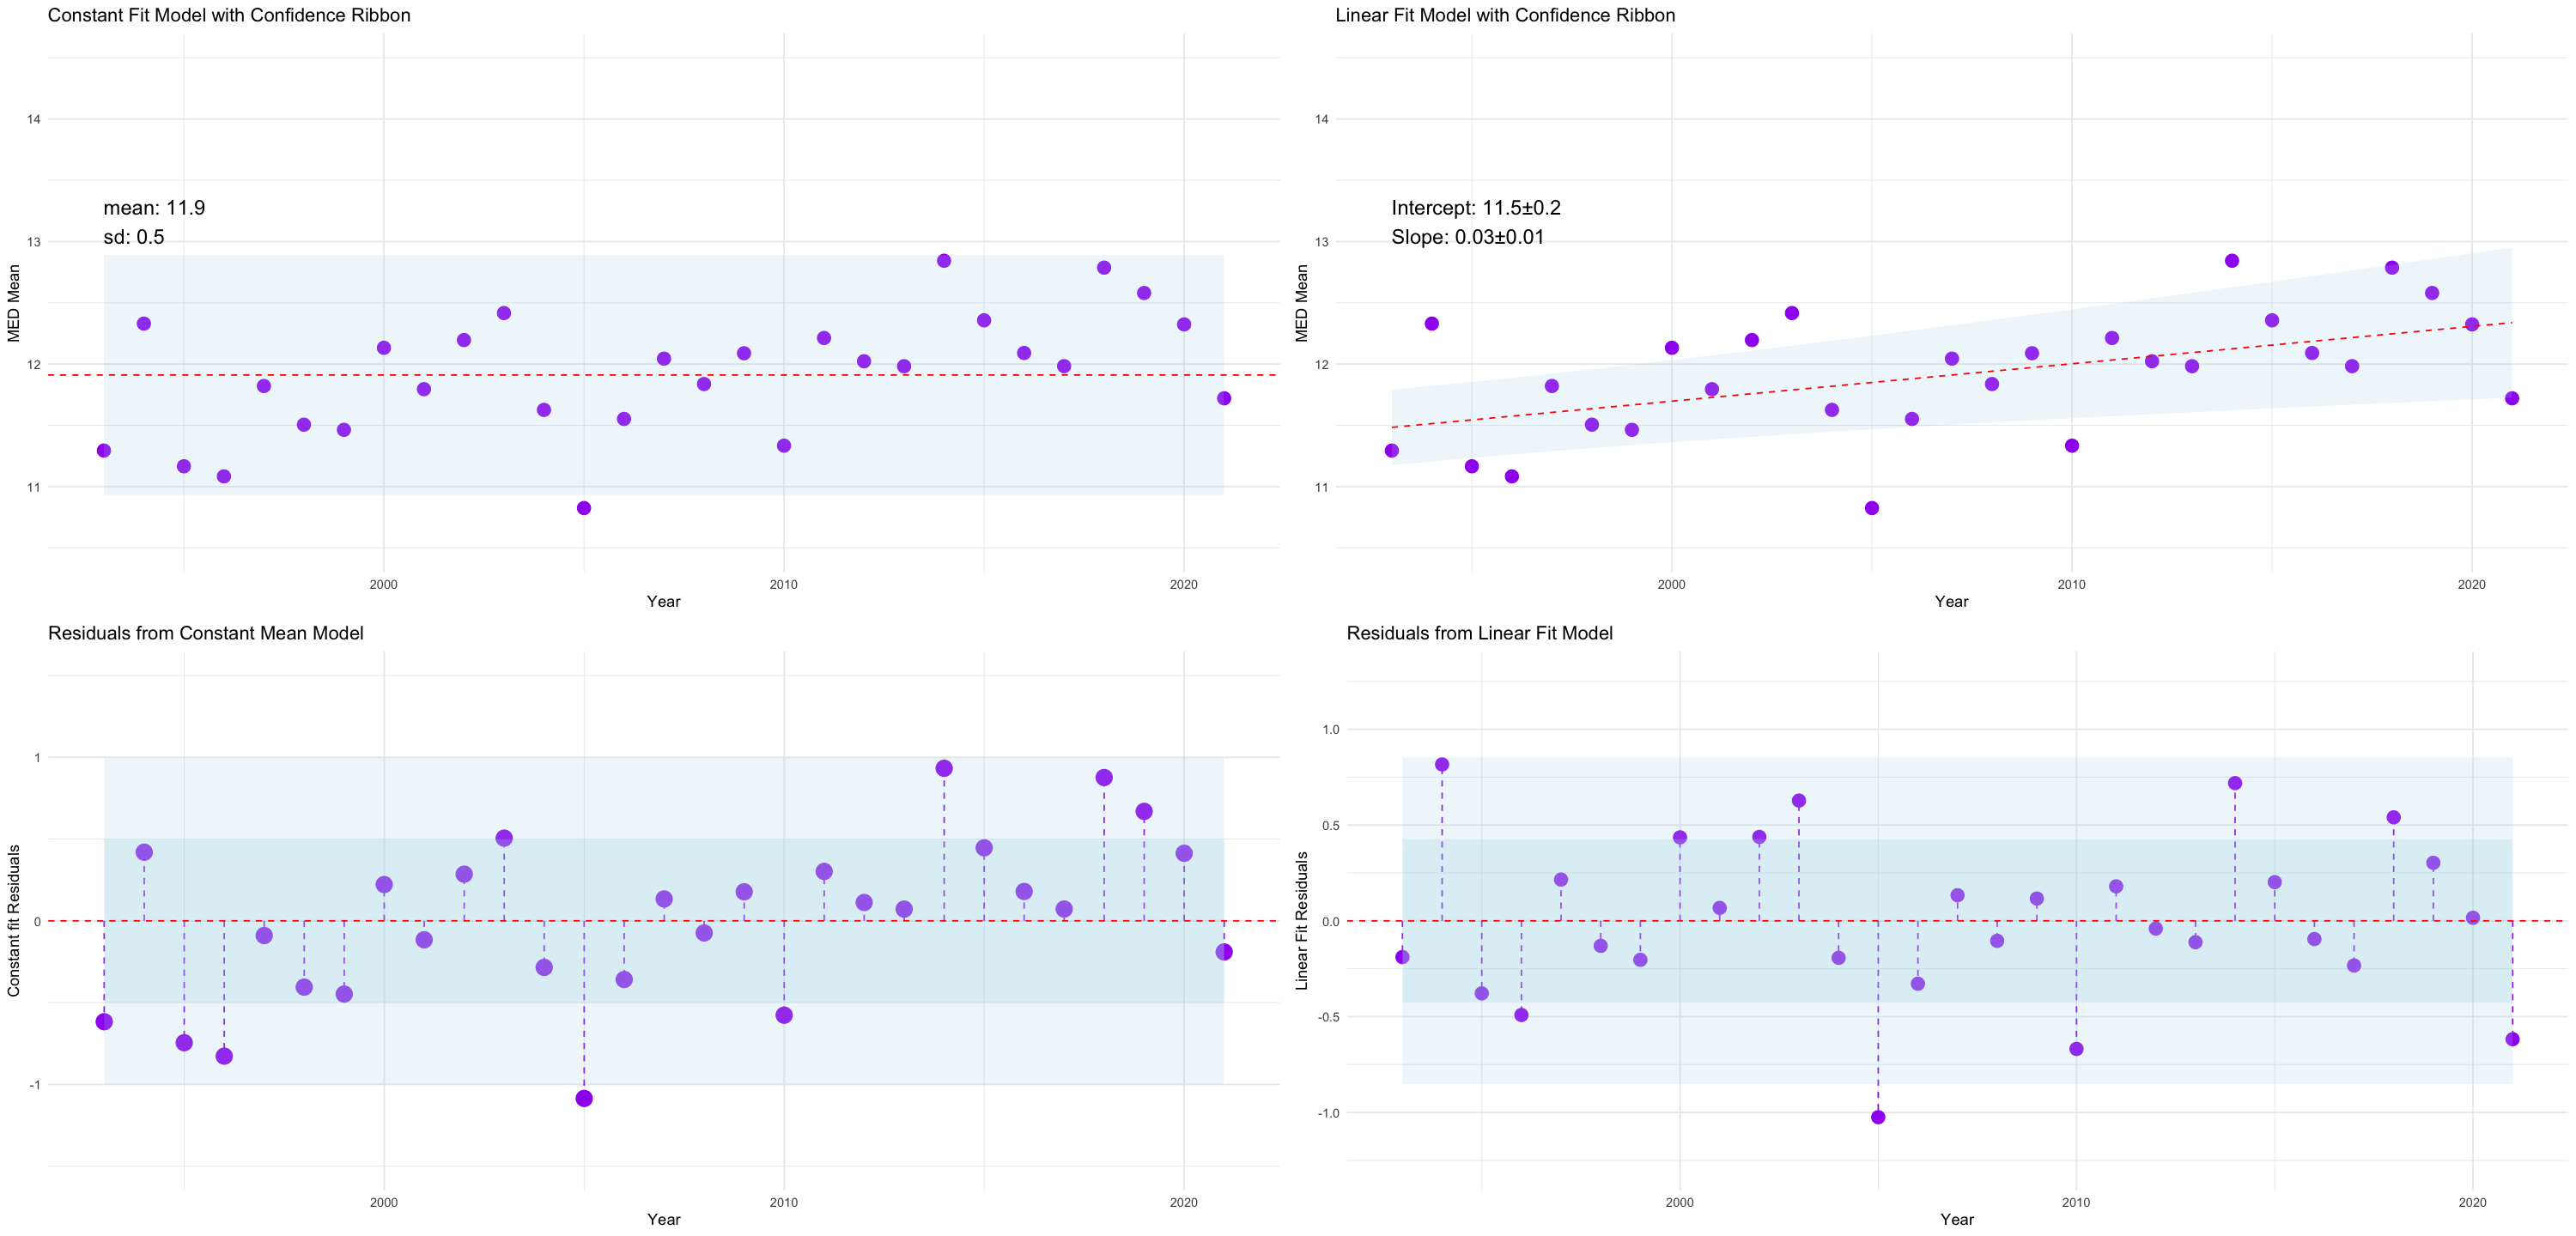

In [6]:

yearly_dataset$x_fit <- yearly_dataset$year_only - 1993


model <- lm(MED_mean ~ x_fit, data = yearly_dataset)
model_summary <- summary(model)
model_coeff_err <- coef(model_summary)[, "Std. Error"]
model_coeff <- coef(model_summary)[, 'Estimate']


fit_dataframe <- yearly_dataset |>
  select(year_only, MED_mean) |>
  mutate(linear_residuals = model$residuals) |>
  mutate(const_residuals = MED_mean - mean(MED_mean)) |>
  mutate(fitted_linear = model$fitted.values)

fit_dataframe <- fit_dataframe |>
  mutate(conf_lower = fitted_linear - 1.96 * sqrt((model_coeff_err[2] * yearly_dataset$x_fit)^2 + (model_coeff_err[1])^2),
         conf_upper = fitted_linear + 1.96 * sqrt((model_coeff_err[2] * yearly_dataset$x_fit)^2 + (model_coeff_err[1])^2)) |>
  mutate(x_fit = yearly_dataset$x_fit)


constant_fit_text <- paste0("mean: ", round(mean(yearly_dataset$MED_mean), 1), 
                            "\nsd: ", round(sqrt(var(yearly_dataset$MED_mean)), 1))


p_a <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = MED_mean), col = 'purple', size = 4) +
  geom_ribbon(aes(x = year_only, ymin = mean(MED_mean) - 1.96*sqrt(var(MED_mean)), 
                  ymax = mean(MED_mean) + 1.96*sqrt(var(MED_mean))), 
              alpha = 0.2, fill = 'lightblue') +
  geom_hline(aes(yintercept = mean(MED_mean)), linetype = 2, color = 'red') +
  theme_minimal() +
  ylim(10.5, 14.5) +
  annotate("text", x = min(fit_dataframe$year_only), y = max(fit_dataframe$MED_mean) + 0.5, 
           label = constant_fit_text, hjust = 0, vjust = 1, size = 5, color = 'black') +
  labs(title = "Constant Fit Model with Confidence Ribbon",
       x = "Year",
       y = "MED Mean")


linear_fit_text <- paste0("Intercept: ", round(model_coeff[1], 1), '\u00B1', round(model_coeff_err[1], 1), 
                          "\nSlope: ", round(model_coeff[2], 2), '\u00B1', round(model_coeff_err[2], 2))

p_b <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = MED_mean), col = 'purple', size = 4) +
  geom_ribbon(aes(x = year_only, ymin = conf_lower, ymax = conf_upper), alpha = 0.2, fill = 'lightblue') +
  geom_line(aes(x = year_only, y = fitted_linear), linetype = 2, col = 'red') +
  theme_minimal() +
  ylim(10.5, 14.5) +
  annotate("text", x = min(fit_dataframe$year_only), y = max(fit_dataframe$MED_mean) + 0.5, 
           label = linear_fit_text, hjust = 0, vjust = 1, size = 5, color = "black") +
  labs(title = "Linear Fit Model with Confidence Ribbon",
       x = "Year",
       y = "MED Mean")

p_c <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = const_residuals), col = 'purple', size = 5) +
  geom_segment(aes(x = year_only, xend = year_only, y = 0, yend = const_residuals), linetype = 2, color = 'purple') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(MED_mean)), ymax = -sqrt(var(MED_mean))), alpha = 0.4, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(MED_mean)), ymax = 2*sqrt(var(MED_mean))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = 2*sqrt(var(MED_mean)), ymax = 3*sqrt(var(MED_mean))), alpha = 0., fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -2*sqrt(var(MED_mean)), ymax = -sqrt(var(MED_mean))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -3*sqrt(var(MED_mean)), ymax = -2*sqrt(var(MED_mean))), alpha = 0., fill = 'lightblue') +
  geom_hline(aes(yintercept = 0), linetype = 2, color = 'red') +
  theme_minimal() +
  labs(title = "Residuals from Constant Mean Model",
       x = "Year",
       y = "Constant fit Residuals")


p_d <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = linear_residuals), col = 'purple', size = 4) +
  geom_segment(aes(x = year_only, xend = year_only, y = 0, yend = linear_residuals), linetype = 2, color = 'purple') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(linear_residuals)), ymax = -sqrt(var(linear_residuals))), alpha = 0.4, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(linear_residuals)), ymax = 2 * sqrt(var(linear_residuals))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = 2 * sqrt(var(linear_residuals)), ymax = 3 * sqrt(var(linear_residuals))), alpha = 0.0, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -2 * sqrt(var(linear_residuals)), ymax = -sqrt(var(linear_residuals))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -3 * sqrt(var(linear_residuals)), ymax = -2 * sqrt(var(linear_residuals))), alpha = 0.0, fill = 'lightblue') +
  geom_hline(aes(yintercept = 0), linetype = 2, color = 'red') +
  theme_minimal() +
  labs(title = "Residuals from Linear Fit Model",
       x = "Year",
       y = "Linear Fit Residuals")


options(repr.plot.width = 25, repr.plot.height = 12)


grid.arrange(p_a, p_b, p_c, p_d, 
             ncol = 2, nrow = 2)


In [7]:
init_variables <- function(model_name) {
    if (model_name == "lin_model") {
        return(function() list(a = runif(1, -20, 20), b = runif(1, -0.5, 0.5), sigma = runif(1, 0, 0.8)))
    } else if (model_name == "const_model") {
        return(function() list(a = runif(1, -20, 20), sigma = runif(1, 0, 0.8)))
    }
}

regression <- function(df, model_file, params) {
    data <- df %>% select(x_fit, MED_mean)
    inits <- init_variables(gsub(".jags", "", model_file))
    jm <- jags.model(model_file, data, inits, n.chains = 1, n.adapt = 1000)
    update(jm, n.iter = 50000)
    chain <- coda.samples(jm, params, n.iter = 1e7, thin = 20)
    return(chain)
}

obtain_quantiles <- function(chain)apply(mcmc_df, 2, quantile, p=c(0.025, 0.25, 0.5, 0.75, 0.975))

trace_plot <- function(chain, type) {
    chain_df <- as.data.frame( as.mcmc(chain) ) 
    chain_df$iteration <- seq.int(nrow(chain_df))
    
    if(type == 'linear'){
        
        plot_a <- ggplot(chain_df, aes(x = iteration, y = a)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of a"),
                x = "Iteration",
                y = 'a') +
            theme_minimal()

        plot_b <- ggplot(chain_df, aes(x = iteration, y = b)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of b"),
                x = "Iteration",
                y = 'b') +
            theme_minimal()
        
        plot_sigma <- ggplot(chain_df, aes(x = iteration, y = sigma)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of sigma"),
                x = "Iteration",
                y = 'sigma') +
            theme_minimal()
        options(repr.plot.width = 25, repr.plot.height = 7)
        return(grid.arrange(plot_a, plot_b, plot_sigma,  ncol = 3, nrow = 1))
    }

    else if(type == 'constant'){
       
        plot_a <- ggplot(chain_df, aes(x = iteration, y = a)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of a"),
                x = "Iteration",
                y = 'a') +
            theme_minimal()

        
        plot_sigma <- ggplot(chain_df, aes(x = iteration, y = sigma)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of sigma"),
                x = "Iteration",
                y = 'sigma') +
            theme_minimal()
        options(repr.plot.width = 25, repr.plot.height = 7)
        return(grid.arrange(plot_a, plot_sigma,  ncol = 2, nrow = 1))
    }    
}

density_plot <- function(chain, type) {
    chain_df <- as.data.frame( as.mcmc(chain) ) 
    quantiles <- summary(chain)$quantiles[,c('2.5%','97.5%')]

    if(type == 'linear'){
        
        lower_a = quantiles['a','2.5%']
        upper_a = quantiles['a','97.5%']
        plot_a <- ggplot(chain_df, aes(x = a)) +
            geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
            geom_vline(aes(xintercept = mean(a)), linetype = 2)+
            geom_vline(aes(xintercept = lower_a), color = 'red')+
            geom_vline(aes(xintercept = upper_a), color = 'red')+
            labs(title = paste("Posterior Distribution of a"),
                x = 'a',
                y = "Density") +
            theme_minimal()

        lower_b = quantiles['b','2.5%']
        upper_b = quantiles['b','97.5%']
        plot_b <- ggplot(chain_df, aes(x = b)) +
            geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
            geom_vline(aes(xintercept = lower_b), color = 'red')+
            geom_vline(aes(xintercept = upper_b), color = 'red')+
            geom_vline(aes(xintercept =mean(b)), linetype = 2)+
            labs(title = paste("Posterior Distribution of b"),
                x = 'b',
                y = "Density") +
            theme_minimal()
        
        lower_sigma = quantiles['sigma','2.5%']
        upper_sigma = quantiles['sigma','97.5%']
        plot_sigma <- ggplot(chain_df, aes(x = sigma)) +
            geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
            geom_vline(aes(xintercept = lower_sigma), color = 'red')+
            geom_vline(aes(xintercept = upper_sigma), color = 'red')+
            geom_vline(aes(xintercept =mean(sigma)), linetype = 2)+
            labs(title = paste("Posterior Distribution of sigma"),
                x = 'sigma',
                y = "Density") +
            theme_minimal()
        options(repr.plot.width = 25, repr.plot.height = 7)
        return(grid.arrange(plot_a, plot_b, plot_sigma,  ncol = 3, nrow = 1))
    }

    else if(type == 'constant'){
       
        lower_a = quantiles['a','2.5%']
        upper_a = quantiles['a','97.5%']
        plot_a <- ggplot(chain_df, aes(x = a)) +
            geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
            geom_vline(aes(xintercept = lower_a), color = 'red')+
            geom_vline(aes(xintercept = upper_a), color = 'red')+
            geom_vline(aes(xintercept =mean(a)), linetype = 2)+
            labs(title = paste("Posterior Distribution of a"),
                x = 'a',
                y = "Density") +
            theme_minimal()

        lower_sigma = quantiles['sigma','2.5%']
        upper_sigma = quantiles['sigma','97.5%']
        plot_sigma <- ggplot(chain_df, aes(x = sigma)) +
            geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
            geom_vline(aes(xintercept = lower_sigma), color = 'red')+
            geom_vline(aes(xintercept = upper_sigma), color = 'red')+
            geom_vline(aes(xintercept =mean(sigma)), linetype = 2)+
            labs(title = paste("Posterior Distribution of sigma"),
                x = 'sigma',
                y = "Density") +
            theme_minimal()
        options(repr.plot.width = 25, repr.plot.height = 7)
        return(grid.arrange(plot_a, plot_sigma,  ncol = 2, nrow = 1))
    }    
}


In [8]:
# Parametri per i modelli
lin_model_file <- "lin_model.jags"
lin_pars <- c("a", "b", "sigma")

const_model_file <- "const_model.jags"
const_pars <- c("a", "sigma")


lin_chain <- regression(yearly_dataset, lin_model_file, lin_pars)
const_chain <- regression(yearly_dataset, const_model_file, const_pars)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 29
   Unobserved stochastic nodes: 3
   Total graph size: 128

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 29
   Unobserved stochastic nodes: 2
   Total graph size: 67

Initializing model



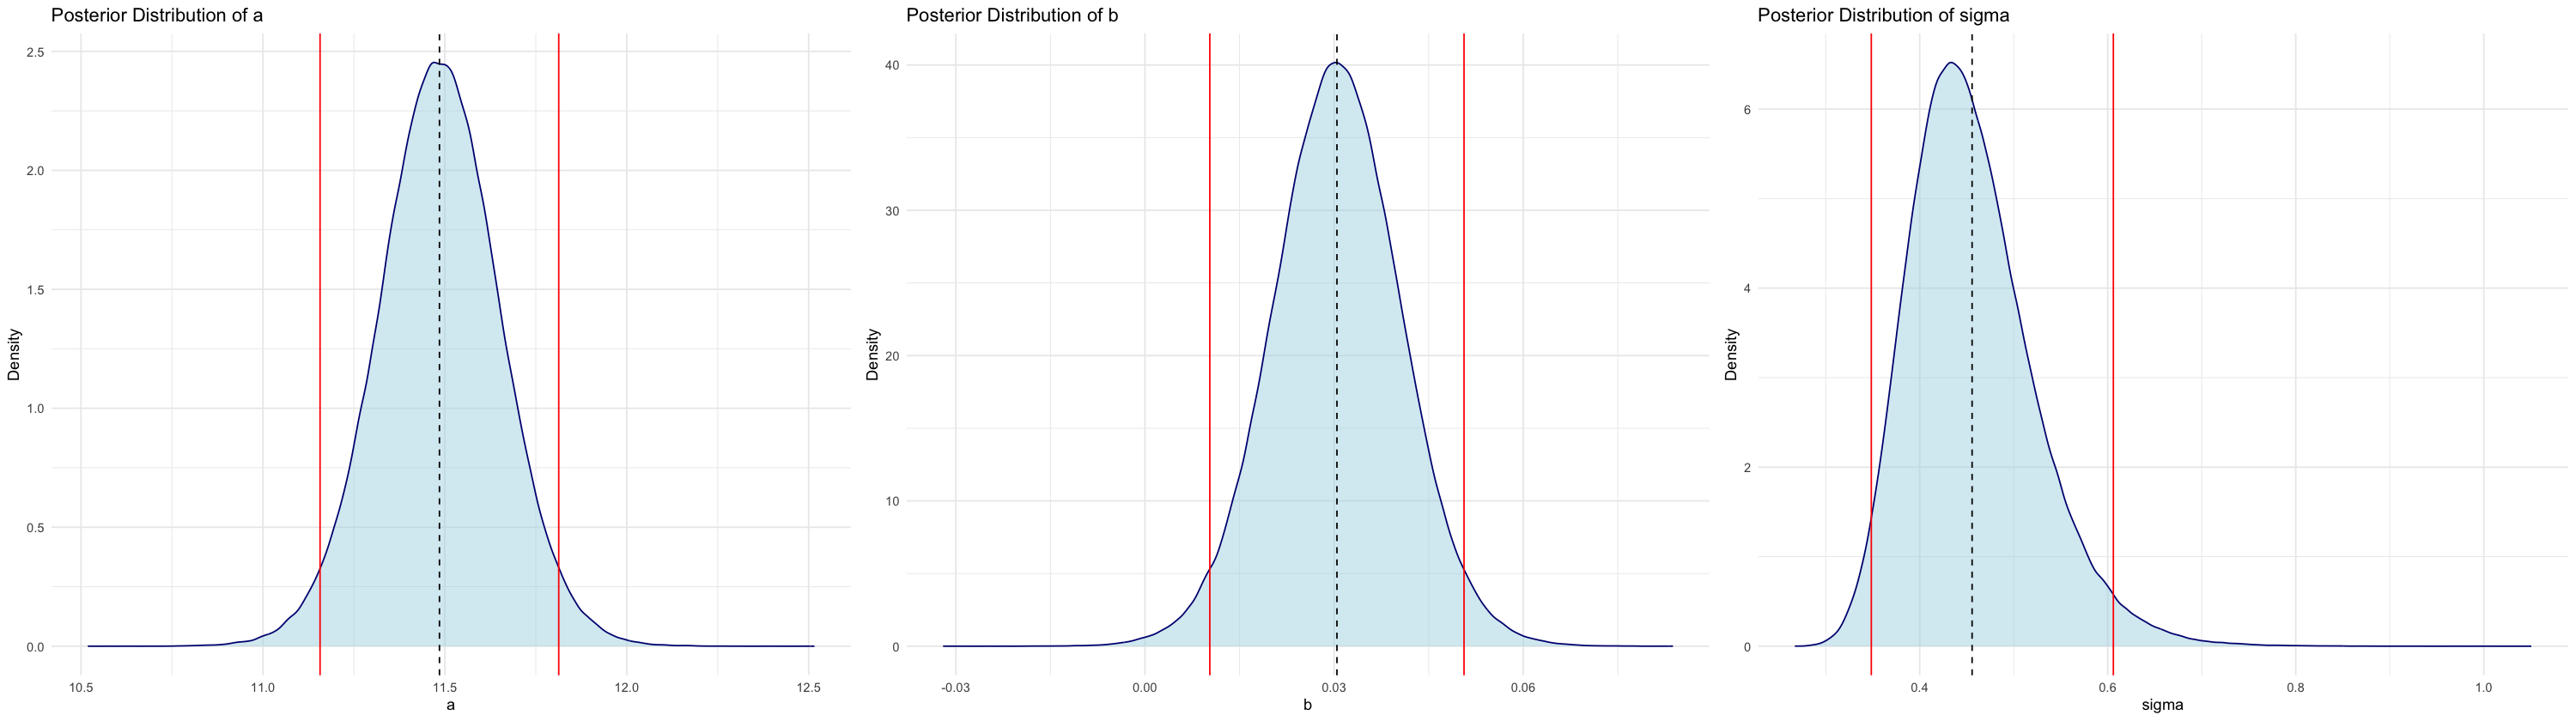

In [12]:
density_plot(lin_chain, 'linear')

In [54]:
get_model_parameters <- function(chain, type) {
    
    chain_df <- as.data.frame( as.mcmc(chain) ) 
    if(type == 'linear'){
        parameters <- list(a = mean(chain_df$a), b = mean(chain_df$b), sigma = mean(chain_df$sigma) )
        return(parameters)
    }
    else if(type == 'constant'){
        parameters <- list(a = mean(chain_df$a), sigma = mean(chain_df$sigma) )
        return(parameters)
    }
}

get_model_prediction <- function(chain, dataset, type){

    if(type == 'linear'){
        parameters <- get_model_parameters(chain,type = 'linear')
        y_pred <- parameters$a + (parameters$b * dataset$MED_mean)
        
    }
    else if(type == 'constant'){
        parameters <- get_model_parameters(chain,type = 'constant')
        y_pred <- parameters$a
    }
    return(y_pred)
}

get_model_likelihood <- function(chain, dataset, type){
    param <- get_model_parameters(chain, type)
    pred <- get_model_prediction(chain, dataset, type)
    obs <- dataset$MED_mean
    return(-1/(2* param$sigma^2)*sum((obs-pred)^2))
}

Statistica del test (D): 6.649397 
Gradi di libert<U+00E0> (df): 1 
p-value: 0.009918938 


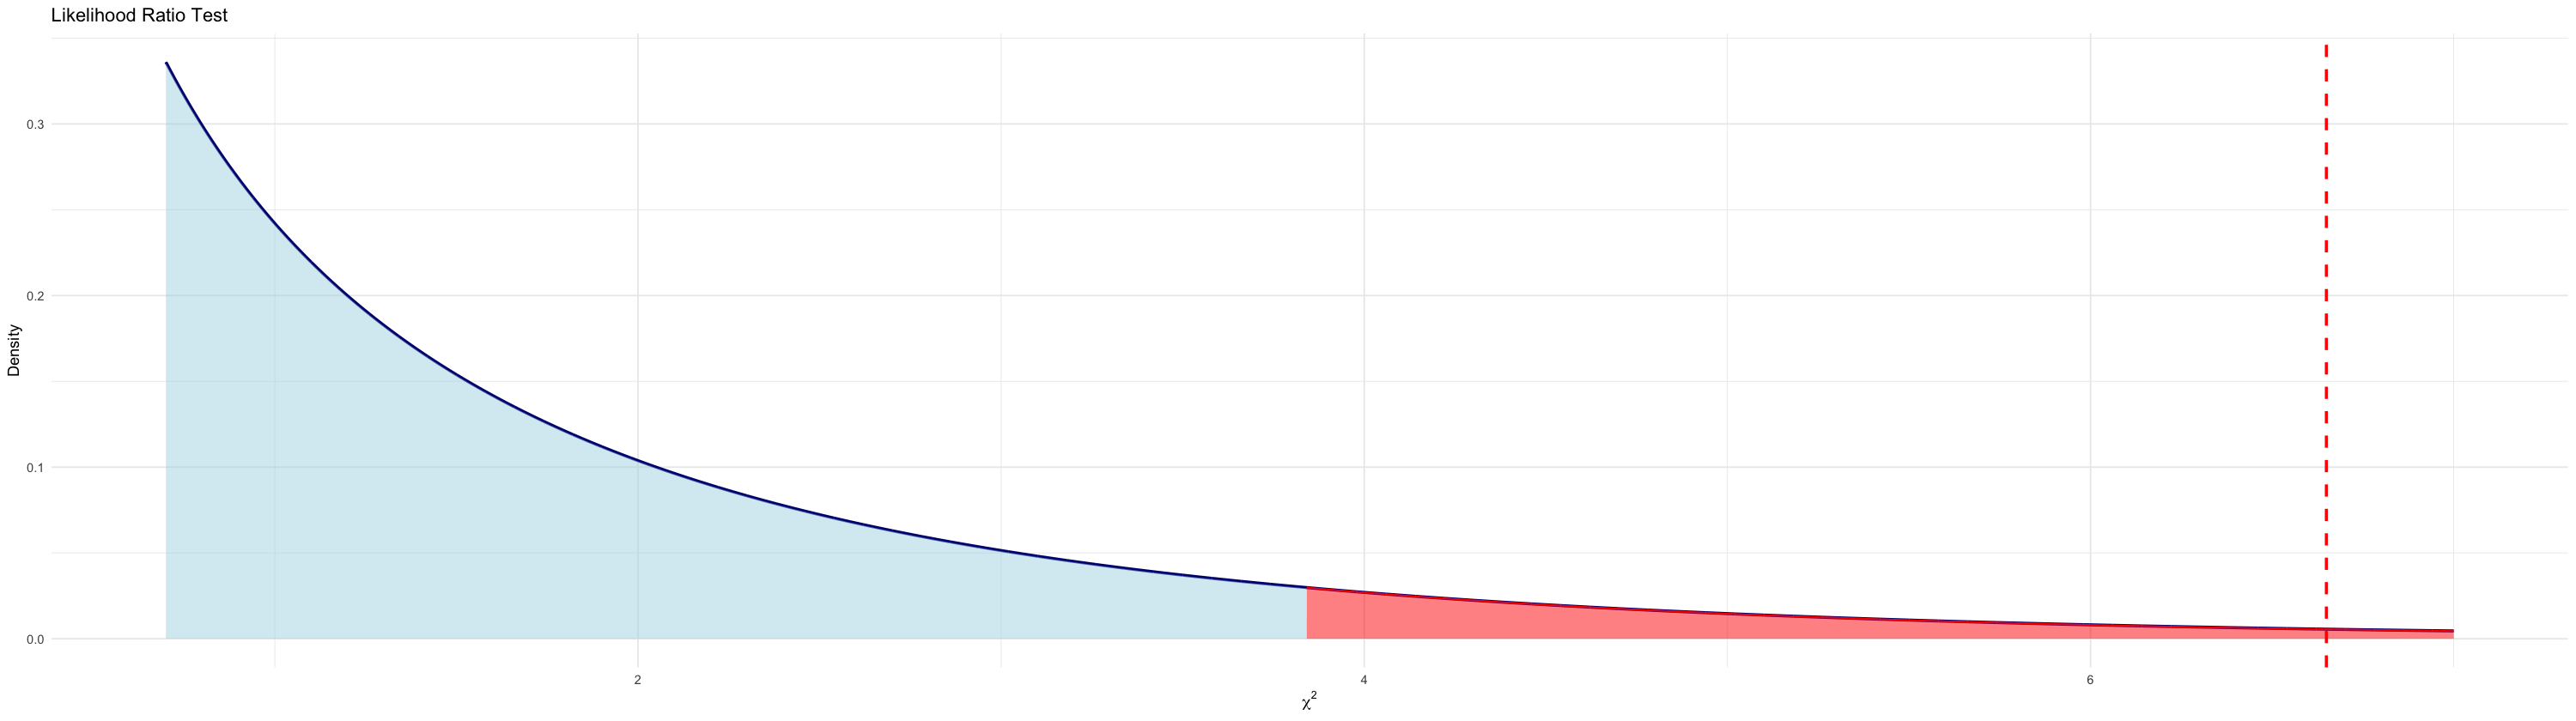

In [97]:
linear_likelihood <- get_model_likelihood(lin_chain, yearly_dataset, type = 'linear')
constant_likelihood <- get_model_likelihood(const_chain, yearly_dataset, type = 'constant')


log_likelihood_ratio <- 2 * (constant_likelihood - linear_likelihood)
degree_freedom <- 1
p_value <- pchisq(log_likelihood_ratio, df = degree_freedom, lower.tail = FALSE)



cat("Statistica del test (D):", log_likelihood_ratio, "\n")
cat("Gradi di libertà (df):", degree_freedom, "\n")
cat("p-value:", p_value, "\n")


x <- seq(0.7, 7, length.out = 10000)
y <- dchisq(x, degree_freedom)
chi_95 <- qchisq(0.95, df = degree_freedom)

data <- data.frame(x = x, y = y)

ggplot(data, aes(x = x, y = y)) +
  geom_line(color = "navy", size = 1) +
  geom_vline(xintercept = log_likelihood_ratio, color = "red", linetype = 2, size = 1) +
  geom_area(data = subset(data, x >= chi_95), aes(x = x, y = y), fill = "red", alpha = 0.5, color = 'red') +
  geom_area(data = subset(data, x <= chi_95), aes(x = x, y = y), fill = "lightblue", alpha = 0.5, color = 'navy') +
  labs(title = "Likelihood Ratio Test",
       x = expression(chi^2),
       y = "Density") +

  theme_minimal()

`summarise()` has grouped output by 'year_only'. You can override using the
`.groups` argument.


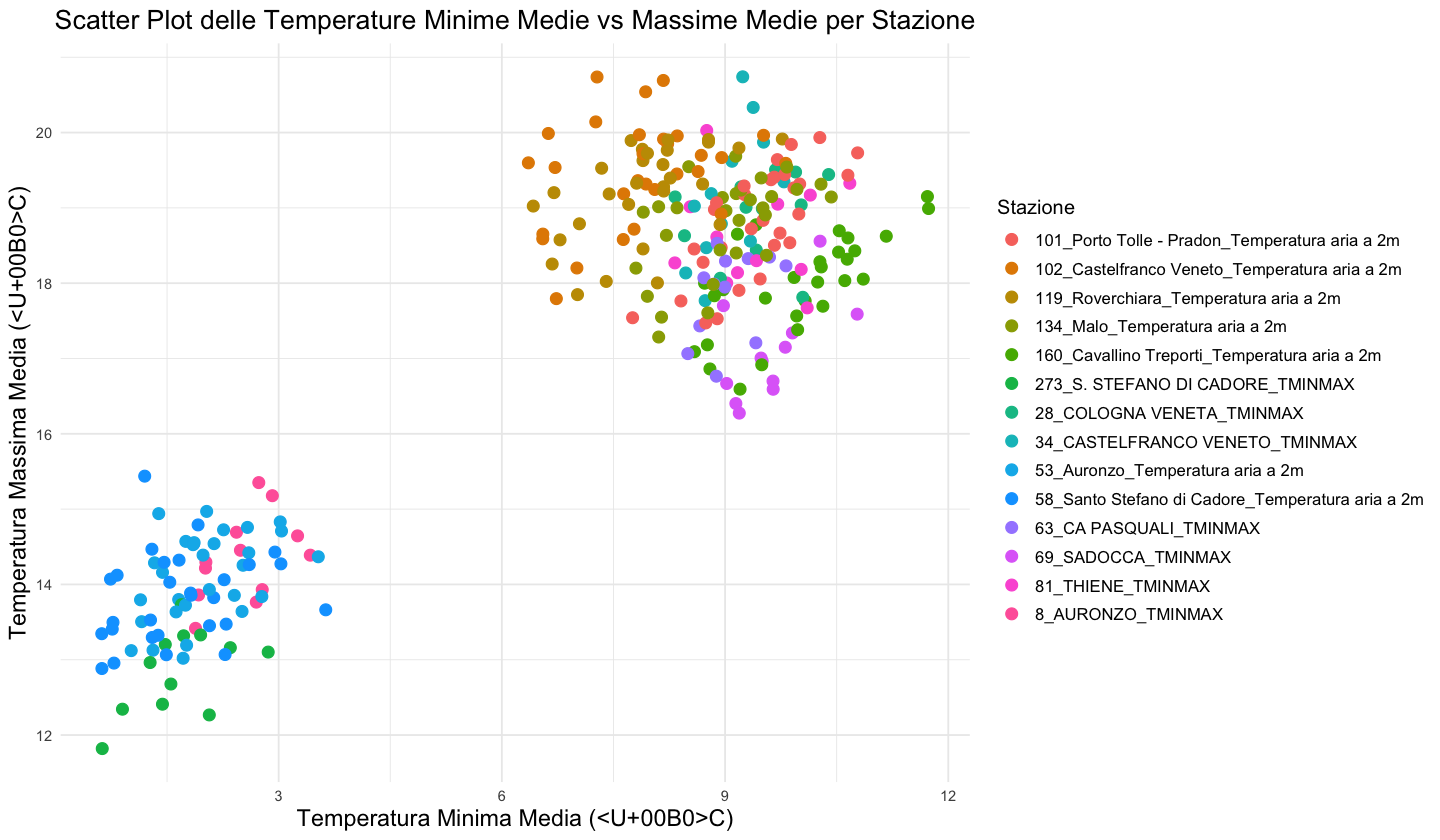

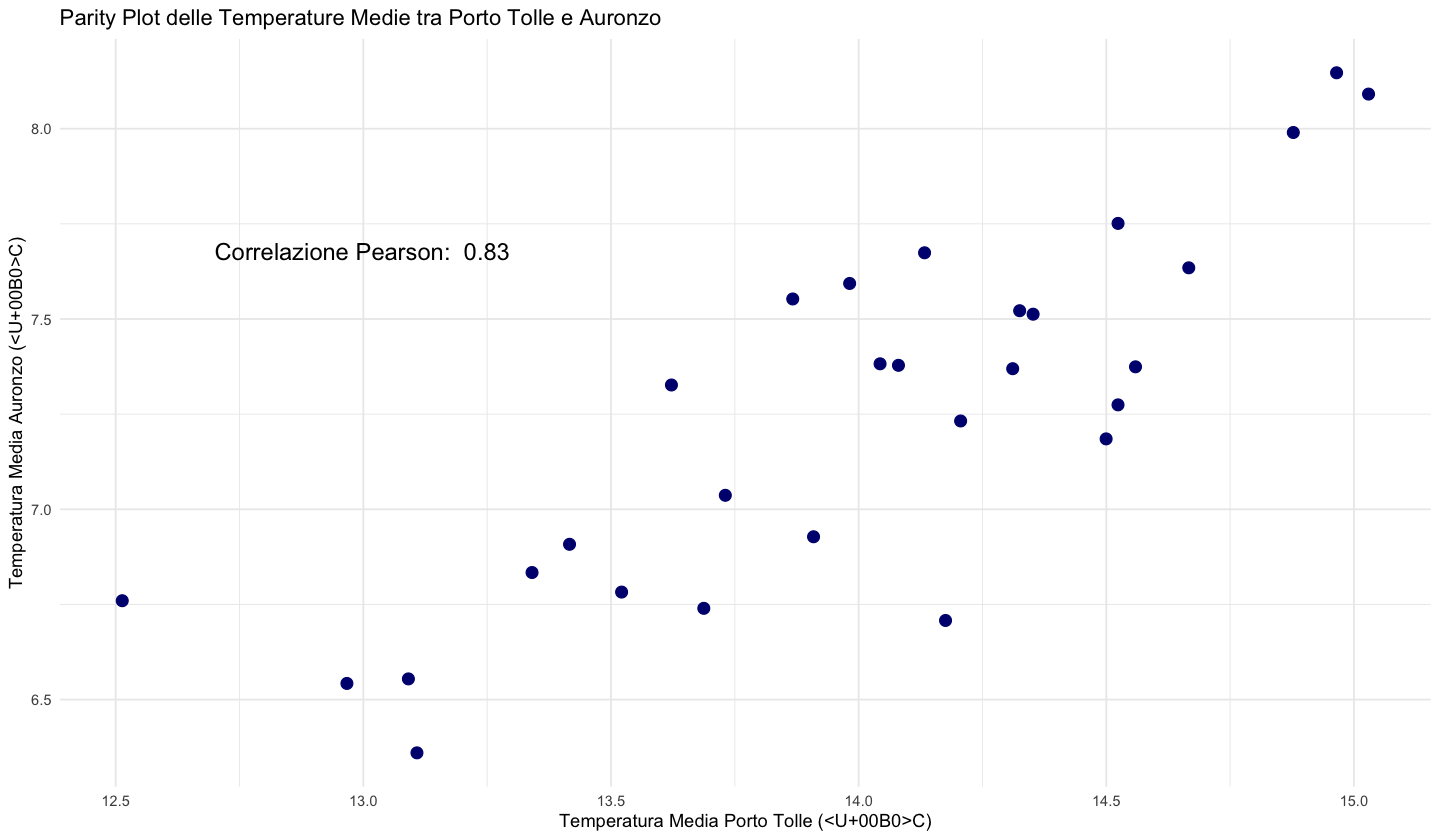

In [163]:

city_dataset <- daily_dataset |>
  group_by(year_only, file) |>
  summarise(MIN_mean = mean(TMIN, na.rm = TRUE),
            MED_mean = mean(TMED, na.rm = TRUE),
            MAX_mean = mean(TMAX, na.rm = TRUE))


porto_tolle <- city_dataset |> filter(file == '101_Porto Tolle - Pradon_Temperatura aria a 2m')
auronzo <- city_dataset |> filter(file == '53_Auronzo_Temperatura aria a 2m')


corr_df <- data.frame(porto_tolle, auronzo)

# Opzioni per la dimensione del plot
options(repr.plot.width = 12, repr.plot.height = 7)


ggplot(city_dataset, aes(x = MIN_mean, y = MAX_mean, color = file)) +
  geom_point(size = 3) +
  labs(
    title = "Scatter Plot delle Temperature Minime Medie vs Massime Medie per Stazione",
    x = "Temperatura Minima Media (°C)",
    y = "Temperatura Massima Media (°C)",
    color = "Stazione"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10)
  )


correlation_pearson <- cor(porto_tolle$MED_mean, auronzo$MED_mean, method = "pearson")
ggplot(corr_df, aes(x = MED_mean, y = MED_mean.1)) +
  geom_point(size = 3, color = 'navy') +
  labs(
    title = "Parity Plot delle Temperature Medie tra Porto Tolle e Auronzo",
    x = "Temperatura Media Porto Tolle (°C)",
    y = "Temperatura Media Auronzo (°C)"
  ) +
  theme_minimal() +
  annotate("text", x = 12.7 , y =7.7, 
           label = paste("Correlazione Pearson: ", round(correlation_pearson, 2)), 
           hjust = 0, vjust = 1, size = 5, color = "black") 

In [141]:
corr_df

year_only,file,MIN_mean,MED_mean,MAX_mean,year_only.1,file.1,MIN_mean.1,MED_mean.1,MAX_mean.1
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1993,101_Porto Tolle - Pradon_Temperatura aria a 2m,7.757067,12.51324,17.54104,1993,53_Auronzo_Temperatura aria a 2m,1.143562,6.759749,13.79562
1994,101_Porto Tolle - Pradon_Temperatura aria a 2m,9.738356,14.13309,18.66493,1994,53_Auronzo_Temperatura aria a 2m,2.259495,7.673967,14.72521
1995,101_Porto Tolle - Pradon_Temperatura aria a 2m,8.406893,12.96684,17.76385,1995,53_Auronzo_Temperatura aria a 2m,1.158356,6.542428,13.50521
1996,101_Porto Tolle - Pradon_Temperatura aria a 2m,8.739891,13.09098,17.47213,1996,53_Auronzo_Temperatura aria a 2m,1.311233,6.554365,13.12676
1997,101_Porto Tolle - Pradon_Temperatura aria a 2m,8.947397,13.62204,18.47233,1997,53_Auronzo_Temperatura aria a 2m,1.752329,7.326598,14.57151
1998,101_Porto Tolle - Pradon_Temperatura aria a 2m,8.584111,13.41631,18.45393,1998,53_Auronzo_Temperatura aria a 2m,1.331507,6.907999,14.28685
1999,101_Porto Tolle - Pradon_Temperatura aria a 2m,8.704384,13.34061,18.27726,1999,53_Auronzo_Temperatura aria a 2m,1.656438,6.833870,13.79945
2000,101_Porto Tolle - Pradon_Temperatura aria a 2m,8.885519,13.86696,19.06831,2000,53_Auronzo_Temperatura aria a 2m,2.131762,7.552611,14.54137
2001,101_Porto Tolle - Pradon_Temperatura aria a 2m,8.857140,13.73082,18.97842,2001,53_Auronzo_Temperatura aria a 2m,1.438947,7.036758,14.16032


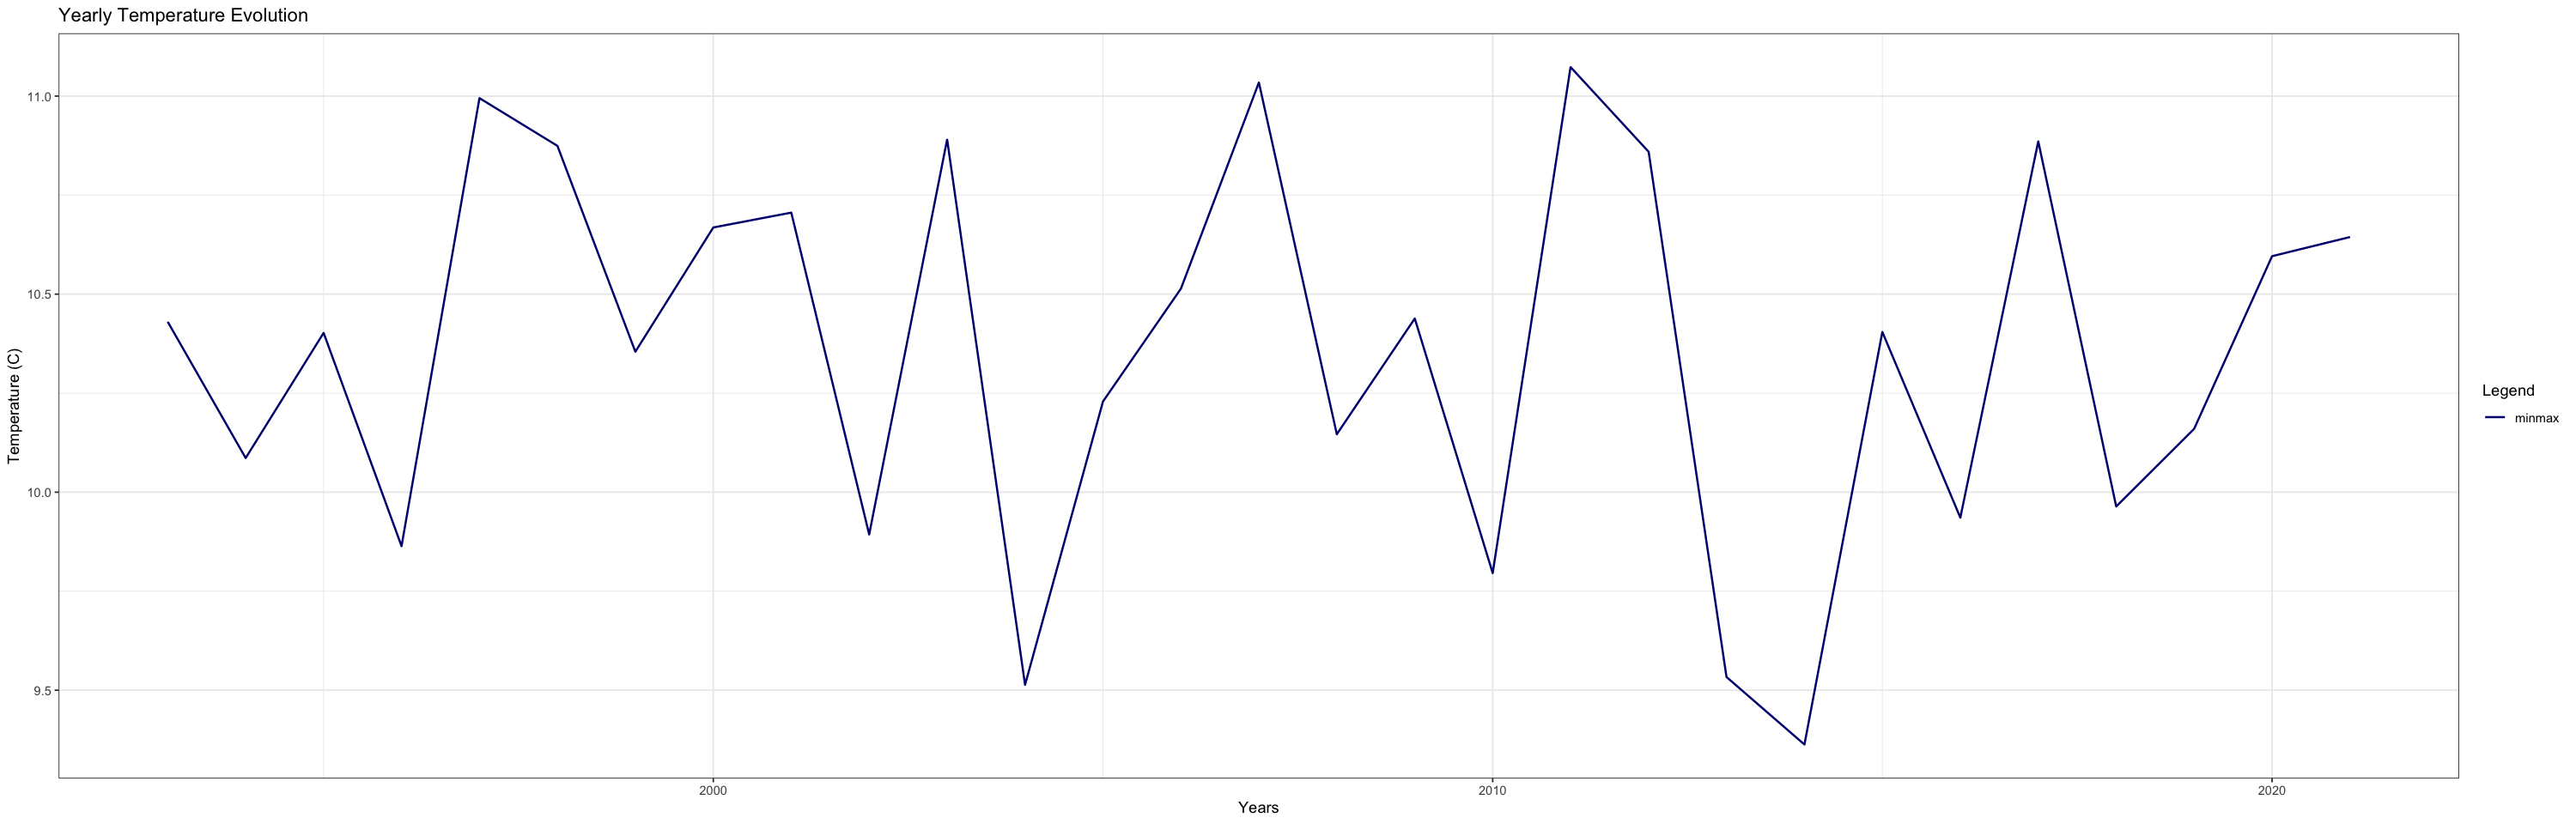

In [123]:
yearly_dataset <- yearly_dataset %>% mutate(MIN_MAX = MAX_mean - MIN_mean)



p_y <- ggplot(data = yearly_dataset) +
  geom_line(aes(x = year_only, y = MIN_MAX, color = 'minmax'), group = 1, linewidth = 0.7) +
  scale_color_manual(name = 'Legend', values = c('minmax' = 'navy')) +
  labs(title = 'Yearly Temperature Evolution',
       x = 'Years',
       y = 'Temperature (C)') +
  theme_bw()

p_y